---

## Merge Generic Dataset

---

Given a time-correlated dataset, do the following:
* visualize
* expose and deal with missing data
* create a date column as a merge point
* merge w/ given aggregate dataset


Requires:
* Project_Util

In [ ]:
import pandas as pd
from datetime import datetime as dt
import datetime

import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

In [ ]:
class Dataset_Merger:
  """
  """
  def __init__(self, data_path, start_date, end_date, freq='1M', debug=False):
    self.data_path = data_path
    self.START_DATE = start_date
    self.END_DATE = end_date
    self.FREQ = freq
    self.DEBUG = debug

    if (len(data_path) <= 0):
      raise AssertionError('Non-zero data_path required')
    if (not start_date or not end_date):
      raise AssertionError('Date bounds required')

    # This is the common merge date field name
    self.DATE_COL='_date_'

    # Ordinal set for scale levels, used for comparison
    self.FREQ_SCALE = {'Y':0, 'M':1, 'D':2}

  def merge_dataset(self, filename, feature_map, df_aggr=None, impute_method='ffill', date_map=None, date_col=None):
    """
    Load data from the given data_path.
    Crop data to given date bounds.
    If date_col is set, will use this to create dates.
    Otherwise supply a  date_map, mapping columns to 'year','month', and 'day'.
    Re-code 'date' as a pd.timestamp.
    Merge into given df_aggr.
    """
    df = self.load_data(filename)
    return self.merge_df(df, feature_map, df_aggr, impute_method, date_map, date_col, filename)

  def merge_df(self, df, feature_map, df_aggr=None, impute_method='ffill', date_map=None, date_col=None, dataset_name='Unknown'):
    """
    Merge data in the given dataframe into given aggregated df.
    Crop data to given date bounds.
    If date_col is set, will use this to create dates.
    Otherwise supply a  date_map, mapping columns to 'year','month', and 'day'.
    Re-code 'date' as a pd.timestamp.
    Merge into given df_aggr.
    """
    if (df_aggr is None):
      self.debug('Defaulting df_aggr to reference df')
      df_aggr = self.get_reference_df()
      # ensure it has a date column for later joins
      df_aggr[self.DATE_COL] = df_aggr.index

    # Grab real column names
    COLS = list(feature_map.values())

    # GUARD
    if (len(COLS) <= 0):
      raise AssertionError(f'{filename} - Provide at least one feature_map entry')

    # Rename columns
    self.debug('Renaming columns', banner=True)
    df.rename(columns=feature_map, inplace=True)
    if (date_map is not None):
      df.rename(columns=date_map, inplace=True)

    df.info()

    # Groom Dates
    # - create std date column
    df = self.preprocess_dates(df, date_col)

    # Drop unnecessary columns    if (target_freq <= src_freq):

    # - this will retain std date column; ensure that exists first
    df = self.trim_columns(df, COLS)

    # Truncate by date
    df = self.snip_dates(df)

    print(df.describe())

    self.debug('Assessing data freq scales')
    # assess granularity of the incoming dataset
    #    and translate into a usable code
    src_freq = self.assess_granularity(df, COLS)
    src_freq = self.FREQ_SCALE[src_freq]
    target_freq = self.FREQ_SCALE[self.FREQ[-1]]
    self.debug(f'src/target: {src_freq}/{target_freq}')

##    if (target_freq <= src_freq):
      # Downscale, even if already on same scale, will align dates
#      df = self.downscale(df, columns=COLS)
#    else:
#      df = self.upscale(df, columns=COLS)
    df = self.downscale(df, src_freq, columns=COLS)

    # Impute Missing Data
    df = self.handle_missing(df, COLS, impute_method)

    # Manual validation of time intervals
    self.print_time_intervals(df)

    # Check num rows as a cheap way to see if dates align
    #   if more rows - do the averaging down
    #   if less rows - impute up
    self.debug(f'df/df_aggr size: {df.shape[0]}/{df_aggr.shape[0]}')
    #self.debug(f'df and df_aggr shapes equivalent...equal? {df.index == df_aggr.index}')
    self.debug(f'pre-merge df::\n{df}')
    self.debug(f'pre-merge df_aggr::\n{df_aggr}')

    # Merge dataset
    self.debug('Merging by date')
    df_merge = df_aggr.merge(df, on=self.DATE_COL, how='inner', suffixes=['', '_df'])
    #TODO: necessary/ harmful??
    df_merge = clean_df(df_merge, ['df'])

    # Plot Data
    self.plot(df_merge, COLS, dataset_name)

    return df_merge

  def debug (self, _str, banner=False):
    if self.DEBUG:
      self.log(_str, banner, prefix='###')

  def log (self, _str, banner=False, prefix=''):
    print('------------------------------------------\n' if banner else '',
          f'{prefix} {_str}')

  def get_reference_df(self):
    """
    Create an empty DataFrame with index set up with dates in a regular pattern
    for the currently set start/end dates and given frequency.
    See https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
    for the full frequency specification.
    """
    # Generate index
    return create_timeindexed_df(self.START_DATE, self.END_DATE, self.FREQ)

  def load_data(self, filename):
    loadfile = self.data_path + filename
    self.debug(f' ============================================================\n  Loading data{loadfile}\n',
      '============================================================')
    return pd.read_csv(loadfile)

  def handle_missing(self, df, COLS, impute_method):
    # Handle missing values
    self.debug(f'Handle missing values via method: {impute_method}...', banner=True)
    self.debug('isna() value counts::')
    df[COLS].isna().value_counts()

    for col in COLS:
      df[col].fillna(method=impute_method, inplace=True)

    self.debug('isna() value counts::')
    df[COLS].isna().value_counts()
    return df

  def preprocess_dates(self, df, date_col=None):
    """
    Does what create_std_date() does but also installs a Datetime index.
    Returns reworked df.
    """
    self.debug(f'preprocess_dates with date_col: {date_col}', banner=True)
    if ('DatetimeIndex' in str(type(df.index))):
      # Start here
      if (self.DATE_COL in df.columns):
        # This appears to create a second _date_ col - skip
        self.debug('Retaining existing DatetimeIndex; done')
      else:
        self.debug('Converting DatetimeIndex into a column')
        df.reset_index(inplace=True)
        df.rename(columns={'index':self.DATE_COL}, inplace=True)

    elif (date_col is not None):
        self.debug(f'Convert from given col {date_col}')
        df[self.DATE_COL] = pd.to_datetime(df[date_col])

    # Ensure DATE_COL and year/month/date cols
    df = self.create_std_date(df)

    # Set date column onto the index
    df.set_index(self.DATE_COL, drop=False, inplace=True)
    # We don't want a name on this that will confuse merge operations
    df.index.name = None

    self.debug(f'{df}')

    return df

  def create_std_date(self, df, add_columns=True):
    """
    Given a timeseries df with either a DataTimeIndex OR some date indicators,
    ensure a standard date column is set.
    If a DateTimeIndex exists, use that.
    If a date_col is specified, start with that and create a standard datetime
    column.
    If piecemeal date artifacts are provided as 'year','month','day', use those in
    order of preference as given.
    Uses pd.to_timestamp().
    Does NOT care to retain the DateTimeIndex.

    """
    self.debug('Creating std date columns', banner=True)
    #self.debug(f'Given cols: {df.columns}')

    # Use cases:
    # 1. Have raw data, need to pull together a standard date column
    # 2. Have a date column, need to ensure the components exist

    if (self.DATE_COL not in list(df.columns)):
      # Case 1
      # We at least need a 'year' column
      if ('year' not in df.columns):
        print(df.info())
        print(df.head())
        raise AssertionError('create_std_date requires a year column')

      datestr = []

      if ('month' in df.columns):
        # Recode as a formatted string
        df['month'] = df['month'].astype(dtype='int32')
        df['monthStr'] = df['month'].apply(lambda x: f'{x:02}')
        datestr.append('{monthStr}/')
      else:
        datestr.append('01/')
        if (add_columns):
          df['month'] = 1

      if ('day' in df.columns):
        # Recode as a formatted string
        df['day'] = df['day'].astype(dtype='int32')
        df['dayStr'] = df['day'].apply(lambda x: f'{x:02}')
        datestr.append('{dayStr}/')
      else:
        datestr.append('01/')
        if (add_columns):
          df['day'] = 1

      # Year string - Recode as a formatted string
      df['year'] = df['year'].astype(dtype='int32')
      df['yearStr'] = df['year'].apply(lambda x: f'{x:4}')
      datestr.append('{yearStr}')
      # Finalize format string
      datestr = "".join(datestr)
      df.info()
      self.debug(f'Using date format: {datestr}')
      df.info()

      # Populate date column
      df[self.DATE_COL] = df.apply(lambda x: pd.to_datetime(datestr.format_map(x)), axis=1)
    else:
      # Case 2
      self.debug(f'## Case 2 for df::\n{df.info}')
      # ensure year/month/day cols exist
      if ('day' not in df.columns):
        df['day'] = df[self.DATE_COL].apply(lambda x: x.day)
      if ('year' not in list(df.columns)):
        df['year'] = df[self.DATE_COL].apply(lambda x: x.year)
      if ('month' not in df.columns):
        df['month'] = df[self.DATE_COL].apply(lambda x: x.month)

    return df

  def snip_dates(self, df):
    """
    Truncates the given df on the set date range.
    Requires a standard date column.
    Assumes index is NOT a DateTimeIndex. If so, it will be removed when index gets reset.
    """
    self.debug(f'Cropping dates to [{self.START_DATE}:{self.END_DATE}]', banner=True)
    if (self.DATE_COL not in df.columns):
      raise AssertionError('snip_dates: df requires date column')

    df = df[df[self.DATE_COL] >= self.START_DATE]
    df = df[df[self.DATE_COL] <= self.END_DATE]

    # Reset index and do not store existing as a  column
    #df.reset_index(inplace=True, drop=True)

    self.debug(f'{df}')

    return df

  def plot(self, df, COLS, filename):
    plt.rcParams["figure.figsize"] = [8,6]
    plt.plot(df[self.DATE_COL], df[COLS])
    plt.xlabel('Date')
    plt.ylabel(filename)
    plt.title(f'{filename} over Time')
    plt.legend(COLS)
    plt.show()

  def print_time_intervals(self, df):
    # Check time intervals
    df['interval'] = df[self.DATE_COL] - df[self.DATE_COL].shift(1)
    df[[self.DATE_COL, 'interval']].head()
    self.debug("------ Interval Counts - should be on the month ------")
    self.debug(f"{df['interval'].value_counts()}")
    df.drop(columns=['interval'], inplace=True)

  def trim_columns(self, df, COLS, retain_dates=True):
    """
    Remove all but the given COLS column names from the given df.
    If our std date column exists in df, ensure that is also retained.
    Returns trimmed df.
    """
    self.debug(f'Trimming columns to {COLS}...', banner=True)
    keep_cols = list(COLS)

    if (retain_dates):
      keep_cols.append(self.DATE_COL)
      keep_cols.append('year')
      keep_cols.append('month')
      keep_cols.append('day')

    return df_retain(df, keep_cols)

  def downscale(self, df, src_freq, columns=None):
    """
    Downscale the given dataset into the timesteps for this Merger.
    Requires input to already contain a std date column.
    """
    self.log(f'Downscaling to freq {self.FREQ}', banner=True)

    # Reference target
    df_ref = self.get_reference_df()
    # use preprocess b/c we only have an index
    df_ref = self.preprocess_dates(df_ref)

    if (df_ref.shape[0] > df.shape[0]):
      print(f'WARN: downscale found missing data in df vs. df_ref: {df.shape[0]} vs. {df_ref.shape[0]}')

    if (self.DATE_COL not in df.columns):
      raise AssertionError('date column required')

    # the columns to work with
    COLS = df.columns if columns is None else columns

    target_freq = self.FREQ[-1]

    # Downscale
    if (target_freq == 'Y'):
      DATE_COLS = ['year']
    elif (target_freq == 'M'):
      # want monthly resolution
      DATE_COLS = ['year','month']
    #TODO support day resolution

    # re-code targetFreq to be numeric
    target_freq = self.FREQ_SCALE[self.FREQ[-1]]
    self.debug(f'src/target freqs: {src_freq}/{target_freq}')

    # Compute net result of df downscaling
    self.debug(f'Grouping df on {DATE_COLS}')
    df_net = df.groupby(DATE_COLS)[COLS].agg(['mean'])

    # Having multiple columns in the COLS array creates columns named as tuples
    #   - clean this up so we can work with them as normal
    df_net = clean_df(df_net)

    # This pulls the date out of the index
    #df_net.reset_index(inplace=True).rename({'index':'year'}, inplace=True)

    # ENSURE that grouped df retains its year/month cols!!
    self.debug(f'Grouped df::\n{df_net}')
    self.debug(f'Reference df::\n{df_ref}')

    # Prepare for merge
    #df_net = self.create_std_date(df_net)

    #df_ref['year'] = df_ref[self.DATE_COL].apply(lambda x: x.year)
    #df_ref['month'] = df_ref[self.DATE_COL].apply(lambda x: x.month)

    self.debug(f'Joining on DATE_COLS: {DATE_COLS}')
    df_merge = df_ref.merge(df_net, how='outer', on=DATE_COLS, suffixes=[None,'net'])

    # Remove unnecessary columns and return merged result
    df_merge = clean_df(df_merge, ['net'])

    # See if there are differences in row size
    diff = diff_df_rows(df_ref, df_merge, debug=True)

    if (diff > 0):
      self.debug(f'Lengths should match: [{df_net.shape[0]},{df_ref.shape[0]}]')
      self.debug(f'ISSUE: sizes do not match::\n---df_net::---\n{df_net}\n---df_merge::---\n{df_merge}')

    #if (target_freq > src_freq):
      # we are upscaling; we may need to impute some data
    for col in COLS:
      if df_merge[col].hasnans:
        df_merge[col].fillna(method='ffill', inplace=True)

    # Remove unnecessary columns and return merged result
    return df_merge

  def upscale(self, df, columns=None):
    """
    Upscale the given dataset into the timesteps for this Merger.
    """
    self.log(f'Upscaling to freq {self.FREQ}', banner=True)

    # Reference dest target
    df_ref = self.get_reference_df()
    # use preprocess b/c we only have an index
    df_ref = self.preprocess_dates(df_ref)

    if (df_ref.shape[0] < df.shape[0]):
      print(f'WARN: upscale found additional data in df vs. df_ref: {df.shape[0]} vs. {df_ref.shape[0]}\n  these may just be rows outside the merger timeframe')

    if (self.DATE_COL not in df.columns):
      raise AssertionError('date column required')

    # the columns to work with
    COLS = df.columns if columns is None else columns

    df = self.create_std_date(df)

    # Gain an understanding of what periodicity exists
    #   in df, b/c we want to select at that level.
    src_freq = self.assess_granularity(df, COLS)
    target_freq = self.FREQ[-1]

    if (target_freq == 'Y'):
      raise AssertionError('Cannot upscale to yearly freq! Try downscaling instead.')

    # Upscale by joining at the level of resolution of the source dataset
    if (src_freq == 'Y'):
      DATE_COLS = ['year']
    elif (src_freq == 'M'):
      DATE_COLS = ['year','month']
    else:
      DATE_COLS = ['year','month','day']

    # Assign values across by joining on right level of freq
    df_merge = df_ref.merge(df, how='outer', on=DATE_COLS, suffixes=[None,'net'])

    # Remove unnecessary columns
    df_merge = clean_df(df_merge, ['net'])

    self.debug(f'Returning upscaled df::\n{df_merge.head()}')
    return df_merge

  def assess_granularity(self, df, COLS):
    """
    Assess the level of granularity of the given dataset.
    Return single character for year/month/day: Y|M|D
    """
    self.debug(f'assess_granularity for cols: {COLS}', banner=True)

    if ('year' not in df.columns):
      raise AssertionError('year column required')
    if ('month' not in df.columns):
      raise AssertionError('month column required')
    if ('day' not in df.columns):
      raise AssertionError('day column required')

    # Compute net number of unique cominations of the given groupings
    #    (current) assumption - if result is <= reference size at y/m/d granularity,
    #    then the dataset is probably given in that level of granularity
    ymd_size = df.groupby(['year','month','day'])[COLS].nunique().shape[0]
    self.debug(f'After grouping y/m/d: {ymd_size}')
    ym_size = df.groupby(['year','month'])[COLS].nunique().shape[0]
    self.debug(f'After grouping y/m: {ym_size}')
    y_size = df.groupby(['year'])[COLS].nunique().shape[0]
    self.debug(f'After grouping y: {y_size}')

    granularity = 'Y'

    if (ymd_size > ym_size):
      granularity = 'D'
    elif(ym_size > y_size):
      granularity = 'M'

    # Retain full-time output
    print(f'Dataset assessed at timestep freq: {granularity}')
    return granularity


---

**Unit Testing**

---

In [ ]:
MD_UNIT_TEST = False

In [ ]:
if MD_UNIT_TEST:
  debug = True

  DRIVE_PATH = "/content/drive/MyDrive/data606"

  # Set the location of this script in GDrive
  SCRIPT_PATH = DRIVE_PATH + "/src/"

  # Root Path of the data on the cloud drive
  DATA_ROOT = DRIVE_PATH + "/data/"

  dataset = "atmospheric-co2.csv"
  feature_map={'Carbon Dioxide (ppm)':'co2', 'Seasonally Adjusted CO2 (ppm)':'co2_seas'}
  date_map={'Year':'year','Month':'month'}

  #dataset = "eruptions-conditioned.csv"
  #feature_map = {'vei':'volcanic_idx'}
  #date_map= {'start_year':'year','start_month':'month'}

  #dataset = "WorldForestCover.csv"
  #feature_map = {'PctCover':'pct_forest_cover'}
  #date_map= {'Year':'year'}


  # Start including data from this date
  start_date =  pd.to_datetime(dt.fromisoformat('1990-01-01'))
  # Stop including data after this date
  end_date = pd.to_datetime(dt.fromisoformat('2020-12-31'))

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  %cd $SCRIPT_PATH

  # Load util class
  %run -i "./ProjectUtil.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data606/src


**Case 1 - reference df**

In [ ]:
  if MD_UNIT_TEST:
    merger = Dataset_Merger(DATA_ROOT, start_date, end_date, debug=True)
    df_ref = merger.get_reference_df()
    print(df_ref.index)

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=372, freq=None)


**Case 2 - Full dataset**

In [ ]:
if MD_UNIT_TEST:
  df = merger.load_data(dataset)
  #print(df.describe().T)

  print(df)

  COLS = list(feature_map.values())

------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/atmospheric-co2.csv

     Year  Month  Decimal Date  Carbon Dioxide (ppm)  \
0    1958      1     1958.0411                   NaN   
1    1958      2     1958.1260                   NaN   
2    1958      3     1958.2027                315.69   
3    1958      4     1958.2877                317.45   
4    1958      5     1958.3699                317.50   
..    ...    ...           ...                   ...   
715  2017      8     2017.6219                   NaN   
716  2017      9     2017.7068                   NaN   
717  2017     10     2017.7890                   NaN   
718  2017     11     2017.8740                   NaN   
719  2017     12     2017.9562                   NaN   

     Seasonally Adjusted CO2 (ppm)  Carbon Dioxide Fit (ppm)  \
0                              NaN                       NaN   
1                 

**Case 2a - preprocess dates**

In [ ]:
if MD_UNIT_TEST:
  df.rename(columns=feature_map, inplace=True)
  df.rename(columns=date_map, inplace=True)

  df = merger.preprocess_dates(df)
  print(df)

------------------------------------------
 ### preprocess_dates with date_col: None
------------------------------------------
 ### Creating std date columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               720 non-null    int32  
 1   month                              720 non-null    int32  
 2   Decimal Date                       720 non-null    float64
 3   co2                                703 non-null    float64
 4   co2_seas                           703 non-null    float64
 5   Carbon Dioxide Fit (ppm)           707 non-null    float64
 6   Seasonally Adjusted CO2 Fit (ppm)  707 non-null    float64
 7   monthStr                           720 non-null    object 
 8   day                                720 non-null    int64  
 9   yearStr                    

**Case 2b - trim columns**

In [ ]:
if MD_UNIT_TEST:
  df = merger.trim_columns(df, COLS)
  print(df)

------------------------------------------
 ### Trimming columns to ['co2', 'co2_seas']...
            year  month     co2  co2_seas  day     _date_
1958-01-01  1958      1     NaN       NaN    1 1958-01-01
1958-02-01  1958      2     NaN       NaN    1 1958-02-01
1958-03-01  1958      3  315.69    314.42    1 1958-03-01
1958-04-01  1958      4  317.45    315.15    1 1958-04-01
1958-05-01  1958      5  317.50    314.73    1 1958-05-01
...          ...    ...     ...       ...  ...        ...
2017-08-01  2017      8     NaN       NaN    1 2017-08-01
2017-09-01  2017      9     NaN       NaN    1 2017-09-01
2017-10-01  2017     10     NaN       NaN    1 2017-10-01
2017-11-01  2017     11     NaN       NaN    1 2017-11-01
2017-12-01  2017     12     NaN       NaN    1 2017-12-01

[720 rows x 6 columns]


**Case 2c - snip dates**

In [ ]:
if MD_UNIT_TEST:
  df = merger.snip_dates(df)
  print(df)

------------------------------------------
 ### Cropping dates to [1990-01-01 00:00:00:2020-12-31 00:00:00]
 ###             year  month     co2  co2_seas  day     _date_
1990-01-01  1990      1  353.66    353.64    1 1990-01-01
1990-02-01  1990      2  354.70    354.02    1 1990-02-01
1990-03-01  1990      3  355.38    353.95    1 1990-03-01
1990-04-01  1990      4  356.20    353.62    1 1990-04-01
1990-05-01  1990      5  357.16    354.05    1 1990-05-01
...          ...    ...     ...       ...  ...        ...
2017-08-01  2017      8     NaN       NaN    1 2017-08-01
2017-09-01  2017      9     NaN       NaN    1 2017-09-01
2017-10-01  2017     10     NaN       NaN    1 2017-10-01
2017-11-01  2017     11     NaN       NaN    1 2017-11-01
2017-12-01  2017     12     NaN       NaN    1 2017-12-01

[336 rows x 6 columns]
            year  month     co2  co2_seas  day     _date_
1990-01-01  1990      1  353.66    353.64    1 1990-01-01
1990-02-01  1990      2  354.70    354.02    1 1990

In [ ]:
if MD_UNIT_TEST:
    src_freq = merger.assess_granularity(df, COLS)
    src_freq = merger.FREQ_SCALE[src_freq]


------------------------------------------
 ### assess_granularity for cols: ['co2', 'co2_seas']
 ### After grouping y/m/d: 336
 ### After grouping y/m: 336
 ### After grouping y: 28
Dataset assessed at timestep freq: M


**Case 2d - print datetime intervals**

In [ ]:
if MD_UNIT_TEST:
  merger.print_time_intervals(df)

 ### ------ Interval Counts - should be on the month ------
 ### 31 days    195
30 days    112
28 days     21
29 days      7
Name: interval, dtype: int64


**Case 2e - downscale**

In [ ]:
if MD_UNIT_TEST:
  df_dwn = merger.downscale(df, src_freq, columns=COLS)
  print(df_dwn)

------------------------------------------
  Downscaling to freq 1M
------------------------------------------
 ### preprocess_dates with date_col: None
 ### Converting DatetimeIndex into a column
------------------------------------------
 ### Creating std date columns
 ### ## Case 2 for df::
<bound method DataFrame.info of         _date_
0   1990-01-01
1   1990-02-01
2   1990-03-01
3   1990-04-01
4   1990-05-01
..         ...
367 2020-08-01
368 2020-09-01
369 2020-10-01
370 2020-11-01
371 2020-12-01

[372 rows x 1 columns]>
 ###                _date_  day  year  month
1990-01-01 1990-01-01    1  1990      1
1990-02-01 1990-02-01    1  1990      2
1990-03-01 1990-03-01    1  1990      3
1990-04-01 1990-04-01    1  1990      4
1990-05-01 1990-05-01    1  1990      5
...               ...  ...   ...    ...
2020-08-01 2020-08-01    1  2020      8
2020-09-01 2020-09-01    1  2020      9
2020-10-01 2020-10-01    1  2020     10
2020-11-01 2020-11-01    1  2020     11
2020-12-01 2020-12-01  

In [ ]:
if MD_UNIT_TEST:
  # Compare ref dates to these dates
  df_ref.shape[0], df_dwn.shape[0]

**Case 2f - full/merge**

In [ ]:
if MD_UNIT_TEST:

  print('merge_dataset() --------------------------------------------------')

  merger = Dataset_Merger(DATA_ROOT, start_date, end_date, freq='1M', debug=True)

  df = merger.get_reference_df()
  df['val'] = pd.Series(data=[i*0.85 for i in range(df.shape[0])], index=df.index)
  df[merger.DATE_COL] = df.index

  print(df)

merge_dataset() --------------------------------------------------
               val     _date_
1990-01-01    0.00 1990-01-01
1990-02-01    0.85 1990-02-01
1990-03-01    1.70 1990-03-01
1990-04-01    2.55 1990-04-01
1990-05-01    3.40 1990-05-01
...            ...        ...
2020-08-01  311.95 2020-08-01
2020-09-01  312.80 2020-09-01
2020-10-01  313.65 2020-10-01
2020-11-01  314.50 2020-11-01
2020-12-01  315.35 2020-12-01

[372 rows x 2 columns]


------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/atmospheric-co2.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               720 non-null    int64  
 1   month                              720 non-null    int64  
 2   Decimal Date                       720 non-null    float64
 3   co2                                703 non-null    float64
 4   co2_seas                           703 non-null    float64
 5   Carbon Dioxide Fit (ppm)           707 non-null    float64
 6   Seasonally Adjusted CO2 Fit (ppm)  707 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 39.5 KB
-----------------------

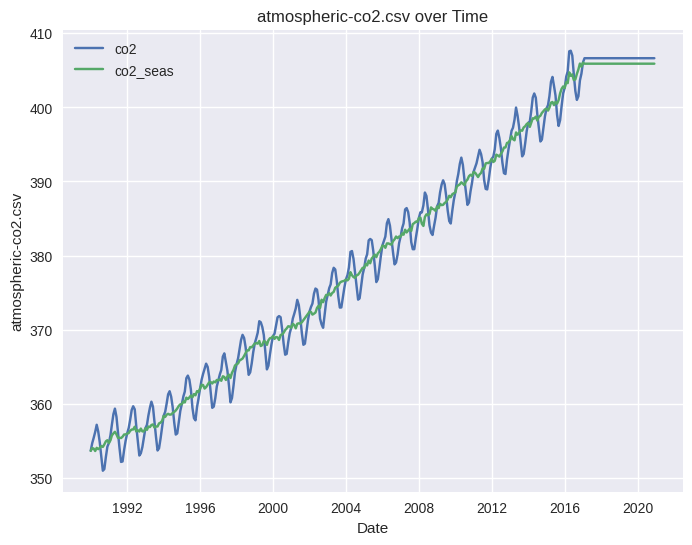

---- Result -----------------------------
        val     _date_  day  year  month     co2  co2_seas
0      0.00 1990-01-01    1  1990      1  353.66    353.64
1      0.85 1990-02-01    1  1990      2  354.70    354.02
2      1.70 1990-03-01    1  1990      3  355.38    353.95
3      2.55 1990-04-01    1  1990      4  356.20    353.62
4      3.40 1990-05-01    1  1990      5  357.16    354.05
..      ...        ...  ...   ...    ...     ...       ...
367  311.95 2020-08-01    1  2020      8  406.64    405.90
368  312.80 2020-09-01    1  2020      9  406.64    405.90
369  313.65 2020-10-01    1  2020     10  406.64    405.90
370  314.50 2020-11-01    1  2020     11  406.64    405.90
371  315.35 2020-12-01    1  2020     12  406.64    405.90

[372 rows x 7 columns]


In [ ]:
if MD_UNIT_TEST:
  df_merge = merger.merge_dataset(dataset,
                                feature_map,
                                df_aggr=df,
                                date_map=date_map)
  print(f'---- Result -----------------------------\n{df_merge}')

**Case 3 - merge daily into monthly**

In [ ]:
if MD_UNIT_TEST:

  print('Case 3: merge your own dataset --------------------------------------------------')

  merger = Dataset_Merger(DATA_ROOT, start_date, end_date, freq='1M', debug=True)
  df = merger.get_reference_df()

  df['val'] = pd.Series(data=[(i+.17)*0.85 for i in range(df.shape[0])], index=df.index)
  df[merger.DATE_COL] = df.index

  print(df)

Case 3: merge your own dataset --------------------------------------------------
                 val     _date_
1990-01-01    0.1445 1990-01-01
1990-02-01    0.9945 1990-02-01
1990-03-01    1.8445 1990-03-01
1990-04-01    2.6945 1990-04-01
1990-05-01    3.5445 1990-05-01
...              ...        ...
2020-08-01  312.0945 2020-08-01
2020-09-01  312.9445 2020-09-01
2020-10-01  313.7945 2020-10-01
2020-11-01  314.6445 2020-11-01
2020-12-01  315.4945 2020-12-01

[372 rows x 2 columns]


In [ ]:
if MD_UNIT_TEST:
  merger2 = Dataset_Merger(DATA_ROOT, start_date, end_date, freq='D', debug=True)
  df2 = merger2.get_reference_df()

  df2['val2'] = pd.Series(data=[(i+.17)*0.35 for i in range(df2.shape[0])], index=df2.index)
  df2[merger2.DATE_COL] = df2.index

  print(df2)

                 val2     _date_
1990-01-01     0.0595 1990-01-01
1990-01-02     0.4095 1990-01-02
1990-01-03     0.7595 1990-01-03
1990-01-04     1.1095 1990-01-04
1990-01-05     1.4595 1990-01-05
...               ...        ...
2020-12-27  3961.3595 2020-12-27
2020-12-28  3961.7095 2020-12-28
2020-12-29  3962.0595 2020-12-29
2020-12-30  3962.4095 2020-12-30
2020-12-31  3962.7595 2020-12-31

[11323 rows x 2 columns]


------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1990-01-01 to 2020-12-31
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   v2      11323 non-null  float64       
 1   _date_  11323 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 265.4 KB
------------------------------------------
 ### preprocess_dates with date_col: None
 ### Retaining existing DatetimeIndex; done
------------------------------------------
 ### Creating std date columns
 ### ## Case 2 for df::
<bound method DataFrame.info of                    v2     _date_
1990-01-01     0.0595 1990-01-01
1990-01-02     0.4095 1990-01-02
1990-01-03     0.7595 1990-01-03
1990-01-04     1.1095 1990-01-04
1990-01-05     1.4595 1990-01-05
...               ...        ...
2020-12-27  3961.3595 2020-12-27
2020-12-28  3961.7095 2020-12-28
2020-12-2

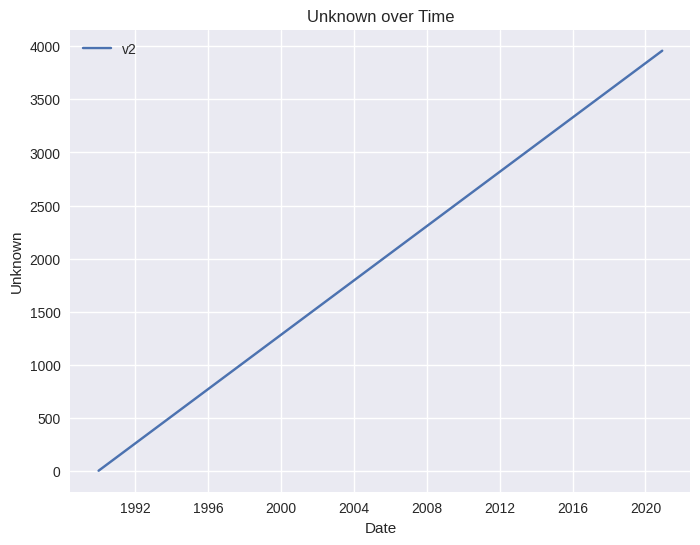

---- Result -----------------------------
          val     _date_  day  year  month         v2
0      0.1445 1990-01-01    1  1990      1     5.3095
1      0.9945 1990-02-01    1  1990      2    15.6345
2      1.8445 1990-03-01    1  1990      3    25.9595
3      2.6945 1990-04-01    1  1990      4    36.6345
4      3.5445 1990-05-01    1  1990      5    47.3095
..        ...        ...  ...   ...    ...        ...
367  312.0945 2020-08-01    1  2020      8  3914.8095
368  312.9445 2020-09-01    1  2020      9  3925.4845
369  313.7945 2020-10-01    1  2020     10  3936.1595
370  314.6445 2020-11-01    1  2020     11  3946.8345
371  315.4945 2020-12-01    1  2020     12  3957.5095

[372 rows x 6 columns]


In [ ]:
if MD_UNIT_TEST:
  df_merge = merger.merge_df(df2,
                              {'val2':'v2'},
                              df_aggr=df)
  print(f'---- Result -----------------------------\n{df_merge}')

**Case 4 - downscale**

In [ ]:
if MD_UNIT_TEST:
  merger = Dataset_Merger(DATA_ROOT, start_date, end_date, freq='D', debug=True)
  df = merger.get_reference_df()

  df['val2'] = pd.Series(data=[(i+.17)*0.35 for i in range(df.shape[0])], index=df.index)
  df[merger.DATE_COL] = df.index

  df = merger.preprocess_dates(df)

  print(df)

------------------------------------------
 ### preprocess_dates with date_col: None
 ### Retaining existing DatetimeIndex; done
------------------------------------------
 ### Creating std date columns
 ### ## Case 2 for df::
<bound method DataFrame.info of                  val2     _date_
1990-01-01     0.0595 1990-01-01
1990-01-02     0.4095 1990-01-02
1990-01-03     0.7595 1990-01-03
1990-01-04     1.1095 1990-01-04
1990-01-05     1.4595 1990-01-05
...               ...        ...
2020-12-27  3961.3595 2020-12-27
2020-12-28  3961.7095 2020-12-28
2020-12-29  3962.0595 2020-12-29
2020-12-30  3962.4095 2020-12-30
2020-12-31  3962.7595 2020-12-31

[11323 rows x 2 columns]>
 ###                  val2     _date_  day  year  month
1990-01-01     0.0595 1990-01-01    1  1990      1
1990-01-02     0.4095 1990-01-02    2  1990      1
1990-01-03     0.7595 1990-01-03    3  1990      1
1990-01-04     1.1095 1990-01-04    4  1990      1
1990-01-05     1.4595 1990-01-05    5  1990      1
...    

In [ ]:
if MD_UNIT_TEST:
  merger2 = Dataset_Merger(DATA_ROOT, start_date, end_date, freq='1M', debug=True)
  df_net = merger2.downscale(df, src_freq, ['val2'])
  print(df_net)
  print('\nMean at month 02::\n',df[(df['year'] == 1990) & (df['month'] == '02')].mean())

------------------------------------------
  Downscaling to freq 1M
------------------------------------------
 ### preprocess_dates with date_col: None
 ### Converting DatetimeIndex into a column
------------------------------------------
 ### Creating std date columns
 ### ## Case 2 for df::
<bound method DataFrame.info of         _date_
0   1990-01-01
1   1990-02-01
2   1990-03-01
3   1990-04-01
4   1990-05-01
..         ...
367 2020-08-01
368 2020-09-01
369 2020-10-01
370 2020-11-01
371 2020-12-01

[372 rows x 1 columns]>
 ###                _date_  day  year  month
1990-01-01 1990-01-01    1  1990      1
1990-02-01 1990-02-01    1  1990      2
1990-03-01 1990-03-01    1  1990      3
1990-04-01 1990-04-01    1  1990      4
1990-05-01 1990-05-01    1  1990      5
...               ...  ...   ...    ...
2020-08-01 2020-08-01    1  2020      8
2020-09-01 2020-09-01    1  2020      9
2020-10-01 2020-10-01    1  2020     10
2020-11-01 2020-11-01    1  2020     11
2020-12-01 2020-12-01  

**Case 5 - upscale Y->M**

In [ ]:
if MD_UNIT_TEST:
  # source merger
  merger = Dataset_Merger(DATA_ROOT, start_date, end_date, freq='Y', debug=True)
  df = merger.get_reference_df()

  df['val2'] = pd.Series(data=[(i+.17)*0.35 for i in range(df.shape[0])], index=df.index)
  df[merger.DATE_COL] = df.index

  print(df)

               val2     _date_
1990-01-01   0.0595 1990-01-01
1991-01-01   0.4095 1991-01-01
1992-01-01   0.7595 1992-01-01
1993-01-01   1.1095 1993-01-01
1994-01-01   1.4595 1994-01-01
1995-01-01   1.8095 1995-01-01
1996-01-01   2.1595 1996-01-01
1997-01-01   2.5095 1997-01-01
1998-01-01   2.8595 1998-01-01
1999-01-01   3.2095 1999-01-01
2000-01-01   3.5595 2000-01-01
2001-01-01   3.9095 2001-01-01
2002-01-01   4.2595 2002-01-01
2003-01-01   4.6095 2003-01-01
2004-01-01   4.9595 2004-01-01
2005-01-01   5.3095 2005-01-01
2006-01-01   5.6595 2006-01-01
2007-01-01   6.0095 2007-01-01
2008-01-01   6.3595 2008-01-01
2009-01-01   6.7095 2009-01-01
2010-01-01   7.0595 2010-01-01
2011-01-01   7.4095 2011-01-01
2012-01-01   7.7595 2012-01-01
2013-01-01   8.1095 2013-01-01
2014-01-01   8.4595 2014-01-01
2015-01-01   8.8095 2015-01-01
2016-01-01   9.1595 2016-01-01
2017-01-01   9.5095 2017-01-01
2018-01-01   9.8595 2018-01-01
2019-01-01  10.2095 2019-01-01
2020-01-01  10.5595 2020-01-01


In [ ]:
if MD_UNIT_TEST:
  # Dest merger
  merger2 = Dataset_Merger(DATA_ROOT, start_date, end_date, freq='1M', debug=True)
  df_net = merger2.upscale(df, ['val2'])
  print(df_net)
  #print('\nMean at month 02::\n',df[(df['year'] == 1990) & (df['month'] == '02')].mean())

------------------------------------------
  Upscaling to freq 1M
------------------------------------------
 ### preprocess_dates with date_col: None
 ### Converting DatetimeIndex into a column
------------------------------------------
 ### Creating std date columns
 ### ## Case 2 for df::
<bound method DataFrame.info of         _date_
0   1990-01-01
1   1990-02-01
2   1990-03-01
3   1990-04-01
4   1990-05-01
..         ...
367 2020-08-01
368 2020-09-01
369 2020-10-01
370 2020-11-01
371 2020-12-01

[372 rows x 1 columns]>
 ###                _date_  day  year  month
1990-01-01 1990-01-01    1  1990      1
1990-02-01 1990-02-01    1  1990      2
1990-03-01 1990-03-01    1  1990      3
1990-04-01 1990-04-01    1  1990      4
1990-05-01 1990-05-01    1  1990      5
...               ...  ...   ...    ...
2020-08-01 2020-08-01    1  2020      8
2020-09-01 2020-09-01    1  2020      9
2020-10-01 2020-10-01    1  2020     10
2020-11-01 2020-11-01    1  2020     11
2020-12-01 2020-12-01    

**Case 5a - upscale Y->M with incomplete time window**

In [ ]:
if MD_UNIT_TEST:
  # using merger to create dataset only
  data_start_date =  pd.to_datetime(dt.fromisoformat('1993-01-01'))
  # Stop including data after this date
  data_end_date = pd.to_datetime(dt.fromisoformat('2000-12-31'))

  merger = Dataset_Merger(DATA_ROOT, data_start_date, data_end_date, freq='Y', debug=True)
  df = merger.get_reference_df()

  df['val2'] = pd.Series(data=[(i+.17)*0.35 for i in range(df.shape[0])], index=df.index)
  df[merger.DATE_COL] = df.index

  print(df)

              val2     _date_
1993-01-01  0.0595 1993-01-01
1994-01-01  0.4095 1994-01-01
1995-01-01  0.7595 1995-01-01
1996-01-01  1.1095 1996-01-01
1997-01-01  1.4595 1997-01-01
1998-01-01  1.8095 1998-01-01
1999-01-01  2.1595 1999-01-01
2000-01-01  2.5095 2000-01-01


In [ ]:
if MD_UNIT_TEST:
  # Dest merger
  merger2 = Dataset_Merger(DATA_ROOT, start_date, end_date, freq='1M', debug=True)
  df_net = merger2.upscale(df, ['val2'])
  print(df_net)
  #print('\nMean at month 02::\n',df[(df['year'] == 1990) & (df['month'] == '02')].mean())

------------------------------------------
  Upscaling to freq 1M
------------------------------------------
 ### preprocess_dates with date_col: None
 ### Converting DatetimeIndex into a column
------------------------------------------
 ### Creating std date columns
 ### ## Case 2 for df::
<bound method DataFrame.info of         _date_
0   1990-01-01
1   1990-02-01
2   1990-03-01
3   1990-04-01
4   1990-05-01
..         ...
367 2020-08-01
368 2020-09-01
369 2020-10-01
370 2020-11-01
371 2020-12-01

[372 rows x 1 columns]>
 ###                _date_  day  year  month
1990-01-01 1990-01-01    1  1990      1
1990-02-01 1990-02-01    1  1990      2
1990-03-01 1990-03-01    1  1990      3
1990-04-01 1990-04-01    1  1990      4
1990-05-01 1990-05-01    1  1990      5
...               ...  ...   ...    ...
2020-08-01 2020-08-01    1  2020      8
2020-09-01 2020-09-01    1  2020      9
2020-10-01 2020-10-01    1  2020     10
2020-11-01 2020-11-01    1  2020     11
2020-12-01 2020-12-01    

**Case 5b - upscale Y->D**

In [ ]:
if MD_UNIT_TEST:
  # source merger
  merger = Dataset_Merger(DATA_ROOT, start_date, end_date, freq='Y', debug=True)
  df = merger.get_reference_df()

  df['val2'] = pd.Series(data=[i*0.35 for i in range(df.shape[0])], index=df.index)
  df[merger.DATE_COL] = df.index

  print(df)

             val2     _date_
1990-01-01   0.00 1990-01-01
1991-01-01   0.35 1991-01-01
1992-01-01   0.70 1992-01-01
1993-01-01   1.05 1993-01-01
1994-01-01   1.40 1994-01-01
1995-01-01   1.75 1995-01-01
1996-01-01   2.10 1996-01-01
1997-01-01   2.45 1997-01-01
1998-01-01   2.80 1998-01-01
1999-01-01   3.15 1999-01-01
2000-01-01   3.50 2000-01-01
2001-01-01   3.85 2001-01-01
2002-01-01   4.20 2002-01-01
2003-01-01   4.55 2003-01-01
2004-01-01   4.90 2004-01-01
2005-01-01   5.25 2005-01-01
2006-01-01   5.60 2006-01-01
2007-01-01   5.95 2007-01-01
2008-01-01   6.30 2008-01-01
2009-01-01   6.65 2009-01-01
2010-01-01   7.00 2010-01-01
2011-01-01   7.35 2011-01-01
2012-01-01   7.70 2012-01-01
2013-01-01   8.05 2013-01-01
2014-01-01   8.40 2014-01-01
2015-01-01   8.75 2015-01-01
2016-01-01   9.10 2016-01-01
2017-01-01   9.45 2017-01-01
2018-01-01   9.80 2018-01-01
2019-01-01  10.15 2019-01-01
2020-01-01  10.50 2020-01-01


In [ ]:
if MD_UNIT_TEST:
  # Dest merger
  merger2 = Dataset_Merger(DATA_ROOT, start_date, end_date, freq='1D', debug=True)
  df_net = merger2.upscale(df, ['val2'])
  print(df_net)
  #print('\nMean at month 02::\n',df[(df['year'] == 1990) & (df['month'] == '02')].mean())

------------------------------------------
  Upscaling to freq 1D
------------------------------------------
 ### preprocess_dates with date_col: None
 ### Converting DatetimeIndex into a column
------------------------------------------
 ### Creating std date columns
 ### ## Case 2 for df::
<bound method DataFrame.info of           _date_
0     1990-01-01
1     1990-01-02
2     1990-01-03
3     1990-01-04
4     1990-01-05
...          ...
11318 2020-12-27
11319 2020-12-28
11320 2020-12-29
11321 2020-12-30
11322 2020-12-31

[11323 rows x 1 columns]>
 ###                _date_  day  year  month
1990-01-01 1990-01-01    1  1990      1
1990-01-02 1990-01-02    2  1990      1
1990-01-03 1990-01-03    3  1990      1
1990-01-04 1990-01-04    4  1990      1
1990-01-05 1990-01-05    5  1990      1
...               ...  ...   ...    ...
2020-12-27 2020-12-27   27  2020     12
2020-12-28 2020-12-28   28  2020     12
2020-12-29 2020-12-29   29  2020     12
2020-12-30 2020-12-30   30  2020     12

**Case 6 - merge of sparse dataset**

In [ ]:
if MD_UNIT_TEST:

  print('Case 6:: merge_dataset() --------------------------------------------------')

  merger = Dataset_Merger(DATA_ROOT, start_date, end_date, freq='1M', debug=True)

Case 6:: merge_dataset() --------------------------------------------------


------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/atmospheric-co2.csv

 ### Defaulting df_aggr to reference df
------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               720 non-null    int64  
 1   month                              720 non-null    int64  
 2   Decimal Date                       720 non-null    float64
 3   co2                                703 non-null    float64
 4   co2_seas                           703 non-null    float64
 5   Carbon Dioxide Fit (ppm)           707 non-null    float64
 6   Seasonally Adjusted CO2 Fit (ppm)  707 non-null    float64
dtypes: float64(5), int64(2)
memor

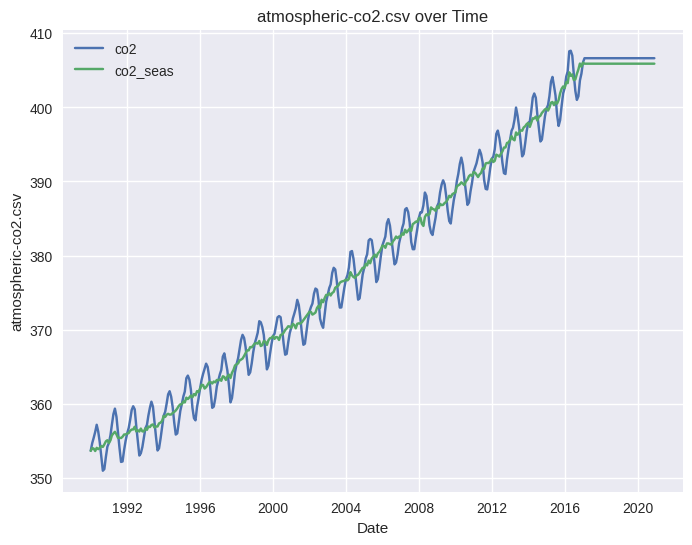

---- Result -----------------------------
        _date_  day  year  month     co2  co2_seas
0   1990-01-01    1  1990      1  353.66    353.64
1   1990-02-01    1  1990      2  354.70    354.02
2   1990-03-01    1  1990      3  355.38    353.95
3   1990-04-01    1  1990      4  356.20    353.62
4   1990-05-01    1  1990      5  357.16    354.05
..         ...  ...   ...    ...     ...       ...
367 2020-08-01    1  2020      8  406.64    405.90
368 2020-09-01    1  2020      9  406.64    405.90
369 2020-10-01    1  2020     10  406.64    405.90
370 2020-11-01    1  2020     11  406.64    405.90
371 2020-12-01    1  2020     12  406.64    405.90

[372 rows x 6 columns]


In [ ]:
if MD_UNIT_TEST:
  df_merge = merger.merge_dataset(dataset,
                                  feature_map,
                                  date_map=date_map)
  print(f'---- Result -----------------------------\n{df_merge}')

In [ ]:
if MD_UNIT_TEST:
  print(assess_na(df_merge))

  _date_  day year month  co2 co2_seas
0    0.0  0.0  0.0   0.0  0.0      0.0
